<a href="https://colab.research.google.com/github/MarinaSupiot/projet_7/blob/main/Dummy_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gc
from hyperopt import hp
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import space_eval, STATUS_OK
import plotly.express as px
from plotly.offline import iplot

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import lightgbm as lgb
#!pip install lime
#from lime import lime_tabular

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pickle
import random
import re
import seaborn as sns
!pip install shap
import shap


import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, fbeta_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

!pip install scikit-plot
!pip install kds

import scikitplot as skplt
import kds

import pickle
import os



import time

# Versions
print('Version des librairies utilisées :')


print('Matplotlib            : ' + mpl.__version__)
print('Missingno             : ' + msno.__version__)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Seaborn               : ' + sns.__version__)
print('Shap                  : ' + shap.__version__)
print('Sklearn               : ' + sklearn.__version__ )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.3 MB/s eta 0:00:00
Version des librairies utilisées :
Matplotlib            : 3.7.1
Missingno             : 0.5.2
NumPy                 : 1.23.5
Pandas                : 1.5.3
Seaborn               : 0.12.2
Shap                  : 0.43.0
Sklearn               : 1.2.2


# Fonctions

In [ ]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

In [ ]:
def timeit(f):
    '''
    fonction décoratrice qui donne le temps d'éxecution d'une autre fonction
    '''
    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed

In [ ]:
def cout_metier(y_true, y_pred, fn_value=-10, fp_value=-1, vp_value=0, vn_value=1):
    mat_conf = confusion_matrix(y_true, y_pred)
    vn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    vp = mat_conf[1, 1]
    J = vp * vp_value + vn * vn_value + fp * fp_value + fn * fn_value
    # Coût maximum
    max_J = (fp + vn)*vn_value + (fn + vp)*vp_value

    # Coût minimum
    min_J = (fp + vn)*fp_value + (fn + vp)*fn_value

    # Coût normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)

    return J_normalized

In [ ]:
from sklearn.dummy import DummyClassifier

@timeit
def optimisation_model(set_data, predictor, metric, n_folds=5, smote=False, under=False, sm_un=False, n_ite_baye=10):
    data = set_data.copy()

    # Extraction des ID
    train_ids = data['SK_ID_CURR']

    # Extraction des targets
    targets = data['TARGET']

    # Remove the ids and target
    data = data.drop(columns=['SK_ID_CURR', 'TARGET'])

    # Fonction de cross-validation
    # Fonction de cross-validation
    # Fonction de cross-validation
    def CV_kfol(X, Y, model_classific, metric, seuil_p, n_folds=5, smote=False, under=False, sm_un=False):

        features = X.copy()
        labels = Y.copy()

        # Extraction des feature names
        feature_names = list(features.columns)

        # Conversion en np arrays
        features = np.array(features)

        # Creation du kfold
        k_fold = StratifiedKfold(n_splits=n_folds, shuffle=True, random_state=seed)

        # Vecteur vide pour feature importances
        feature_importance_values = np.zeros(len(feature_names))

        # Vecteur vide pour prediction sur validation
        prediction = np.zeros(features.shape[0])

        # Liste pour stocker les validation et training scores
        valid_scores = []

        # Boucle pour chaque fold
        n_boucl = 0
        for train_indices, valid_indices in k_fold.split(features):
            n_boucl += 1
            model = model_classific

            # Training data
            train_features, train_labels = features[train_indices], labels[train_indices]

            # rééquilibrage
            if smote == True:
                sm = SMOTE(random_state=seed, k_neighbors=10)
                train_features, train_labels = sm.fit_resample(train_features, train_labels)

            elif under == True:
                us = RandomUnderSampler(sampling_strategy='majority', random_state=seed)
                train_features, train_labels = us.fit_resample(train_features, train_labels)

            elif sm_un == True:
                sm = SMOTE(sampling_strategy=0.2, random_state=seed, k_neighbors=10)
                X_train_resampled, y_train_resampled = sm.fit_resample(train_features, train_labels)
                us = RandomUnderSampler(sampling_strategy=1, random_state=seed)
                train_features, train_labels = us.fit_resample(X_train_resampled, y_train_resampled)

            # Validation data
            valid_features, valid_labels = features[valid_indices], labels[valid_indices]

            # Train du model
            model.fit(train_features, train_labels)

            # Récupération du best_iteration
            best_iteration = getattr(model, 'best_iteration_', None)

            # Récupération des feature importances
            if hasattr(model, 'feature_importances_'):
                feature_importance_values += model.feature_importances_ / k_fold.n_splits

            # Récupération des predictions des validations
            if best_iteration is not None:
                prediction[valid_indices] = model.predict_proba(valid_features, num_iteration=best_iteration)[:, 1]
            else:
                prediction[valid_indices] = model.predict_proba(valid_features)[:, 1]

            y_pred = (prediction[valid_indices] > seuil_p)
            y_pred = np.array(y_pred > 0) * 1

            # Evaluation du model avec la metric
            valid_score = metric(labels[valid_indices], y_pred, seuil_p)
            # print('score de la boucle CV =',valid_score)

            # Récupération des best score
            valid_scores.append(valid_score)

            # Clean mémoire
            gc.enable()
            del model, train_features, valid_features
            gc.collect()

        return valid_scores

    # np.random.seed(42)
    # Fonction a optimiser
    def optimize_rf(params,
                    model_optim=predictor,
                    X=data,
                    Y=targets,
                    metric=metric,
                    n_folds=n_folds,
                    smote=smote,
                    under=under,
                    sm_un=sm_un
                    ):
        params_model = {'strategy': 'stratified'}

        model_optim.set_params(**params_model)
        seuil_p = params['seuil']

        # Cross validation
        valid_score = CV_kfol(X,
                              Y,
                              model_optim,
                              metric,
                              seuil_p,
                              n_folds=n_folds,
                              smote=smote,
                              under=under,
                              sm_un=sm_un
                              )

        # Moyenne des score de validation
        valid_loss_moy = 1 - np.mean(valid_score)

        return valid_loss_moy

    np.random.seed(42)
    # espace des parameters
    space = {'seuil': hp.quniform('seuil', 0.0, 1.0, 0.025)}

    # Optimisation
    optim = fmin(fn=optimize_rf,
                 space=space,
                 algo=tpe.suggest,  # selection des paramètre automatiquement
                 max_evals=n_ite_baye,  # nb iterations
                 rstate=np.random.seed(42)
                 )

    # configuration du modèle avec les paramètres optimisés
    predictor.set_params(strategy='stratified')

    return optim, predictor


In [ ]:
@timeit
def afficher_matrice_confusion(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)

    #labels = ['Non défaillants', 'Défaillants']

    group_names = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm,
                #xticklabels=labels,
                #yticklabels=labels,
                annot=labels,
                fmt='',
                cmap=plt.cm.Blues)
    plt.title(f'Matrice de confusion de : {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()

In [ ]:
def score_validation_set(model):
    '''
    Fonction de prédiction sur le set de validation
    '''
    name=[]
    score=[]
    target_0=[]
    target_1=[]
    target_0_1=[]
    target_1_1=[]
    seuil=0.52
    for i,j in model.items():
        y_test_proba=j.predict_proba(val_set.drop(['TARGET'],axis=1))[:, 1]
        name.append(i)
        y_pred = j.predict(val_set.drop(['TARGET'],axis=1))
        score.append(cout_metier(val_set['TARGET'],y_pred))


        y_seuil_test=[]
        for i in y_test_proba:
            if i >= seuil:
                y_seuil_test.append(1)
            elif i < seuil:
                y_seuil_test.append(0)

        pred_frame=pd.DataFrame(y_seuil_test)
    #display(pred_frame)
        target_0_1.append((pred_frame.value_counts()/len(pred_frame)*100)[0].item())
        target_0.append((pred_frame.value_counts())[0].item())
        target_1_1.append((pred_frame.value_counts()/len(pred_frame)*100)[1].item())
        target_1.append((pred_frame.value_counts())[1].item())


    return name,score,target_0_1, target_0, target_1_1, target_1

## Import train et test df

## Modélisation

In [ ]:
seed = 42

In [ ]:
#chargement des train set et val set
train_set = pickle.load( open( "/content/drive/MyDrive/Projet 7/train_set.p", "rb" ) )
val_set = pickle.load( open( "/content/drive/MyDrive/Projet 7/val_set.p", "rb" ) )
train_labels = pickle.load( open( "/content/drive/MyDrive/Projet 7/train_labels.p", "rb" ) )
val_labels = pickle.load( open( "/content/drive/MyDrive/Projet 7/val_labels.p", "rb" ) )


In [ ]:
train_sample_set = pickle.load( open( "/content/drive/MyDrive/Projet 7/train_sample_set.p", "rb" ) )
val_sample_set = pickle.load( open( "/content/drive/MyDrive/Projet 7/val_sample_set.p", "rb" ) )
train_sample_labels = pickle.load( open( "/content/drive/MyDrive/Projet 7/train_sample_labels.p", "rb" ) )
val_sample_labels = pickle.load( open( "/content/drive/MyDrive/Projet 7/val_sample_labels.p", "rb" ) )

## Rééquilibrage et choix du modèle

In [ ]:
best_par_0,  model_0 = optimisation_model(train_sample_set, DummyClassifier(strategy='stratified',random_state=seed),metric = cout_metier, n_ite_baye=5)

100%|██████████| 5/5 [00:04<00:00,  1.00trial/s, best loss: 0.04793286972223032]
Durée d'exécution de optimisation_model: 5.016547203063965s


### Metrics vs Threshold

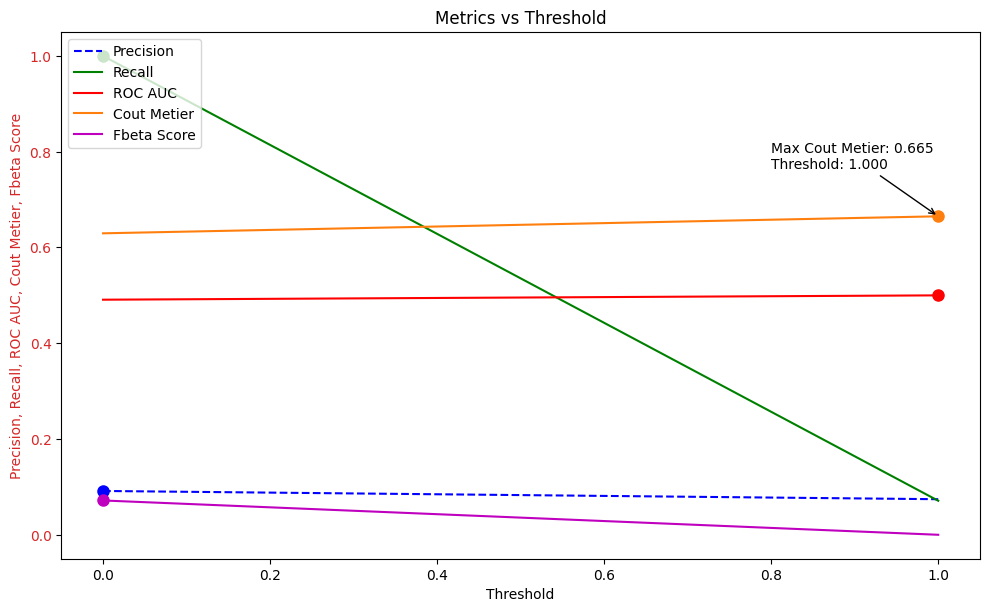

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, fbeta_score


# Assuming X_train is your training features, y_train is your training labels, and model_smote is your trained model
# Metrics to visualize
metrics_to_visualize = [roc_auc_score, recall_score, f1_score, precision_score, fbeta_score]


# Function to calculate metrics at different thresholds
def calculate_metrics(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]
    fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds]

    return thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores

# Function to plot metrics vs threshold
def plot_metrics_vs_threshold(X, y, model, metrics_to_visualize):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores = calculate_metrics(X, y, model)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision, Recall, ROC AUC, Cout Metier, Fbeta Score', color='tab:red')
    ax1.plot(thresholds, precision[:-1], 'b--', label='Precision')
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax1.plot(thresholds, roc_auc, 'r-', label='ROC AUC')
    ax1.plot(thresholds, cout_metier_values, 'tab:orange', label='Cout Metier')
    ax1.plot(thresholds, fbeta_scores, 'm-', label='Fbeta Score')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    ax1.legend(loc='upper left')

    # Mark maximum values
    max_precision_idx = np.argmax(precision[:-1])
    max_recall_idx = np.argmax(recall[:-1])
    max_roc_auc_idx = np.argmax(roc_auc)
    max_cout_metier_idx = np.argmax(cout_metier_values)
    max_fbeta_score_idx = np.argmax(fbeta_scores)

    ax1.plot(thresholds[max_precision_idx], precision[:-1][max_precision_idx], 'bo', markersize=8, label='Max Precision')
    ax1.plot(thresholds[max_recall_idx], recall[:-1][max_recall_idx], 'go', markersize=8, label='Max Recall')
    ax1.plot(thresholds[max_roc_auc_idx], roc_auc[max_roc_auc_idx], 'ro', markersize=8, label='Max ROC AUC')
    ax1.plot(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx], 'o', color='tab:orange', markersize=8, label='Max Cout Metier: {:.3f} (Threshold: {:.3f})'.format(cout_metier_values[max_cout_metier_idx], thresholds[max_cout_metier_idx]))
    ax1.plot(thresholds[max_fbeta_score_idx], fbeta_scores[max_fbeta_score_idx], 'mo', markersize=8, label='Max Fbeta Score: {:.3f} (Threshold: {:.3f})'.format(fbeta_scores[max_fbeta_score_idx], thresholds[max_fbeta_score_idx]))

    # Annotate the maximum Cout Metier value
    ax1.annotate(
        f'Max Cout Metier: {cout_metier_values[max_cout_metier_idx]:.3f}\nThreshold: {thresholds[max_cout_metier_idx]:.3f}',
        xy=(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx]),
        xytext=(thresholds[max_cout_metier_idx] - 0.2, cout_metier_values[max_cout_metier_idx] + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
    )

    fig.tight_layout()
    plt.title('Metrics vs Threshold')
    plt.show()

# usage
plot_metrics_vs_threshold(val_sample_set.drop(columns=['TARGET']), val_sample_labels, model_0, metrics_to_visualize)


### Metrics

In [ ]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
y_proba = model_0.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba = y_proba > 0.99
y_pred_proba = np.array(y_pred_proba > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score= roc_auc_score(val_sample_labels,y_proba)

# recall
recall = recall_score(val_sample_labels,y_pred_proba)


# precision
precision = precision_score(val_sample_labels, y_pred_proba)

# F1
f1 = f1_score(val_sample_labels, y_pred_proba)

#Fbeta
fbeta = fbeta_score(val_sample_labels, y_pred_proba, beta=2)

print("ROC auc score : ", score)
print("Métrique métier : ", cout_metier(val_sample_labels, y_pred_proba))
print("Rappel (recall):", recall)
print("Précision :", precision)
print("F1-score :", f1)
print("Fbeta-score  :", fbeta)

ROC auc score :  0.49094014934844266
Métrique métier :  0.6295754026354319
Rappel (recall): 0.07103825136612021
Précision : 0.07428571428571429
F1-score : 0.07262569832402235
Fbeta-score  : 0.07166482910694598


### Lift Curve

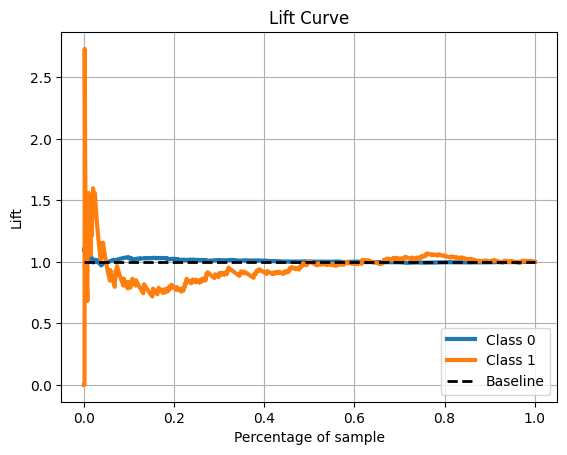

In [ ]:
# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_0.predict_proba(val_sample_set.drop(columns=['TARGET']))
skplt.metrics.plot_lift_curve(val_sample_labels, y_proba)
plt.show()

#skplt.metrics.plot_lift_curve(val_sample_labels, model_us.predict_proba(val_sample_set.drop(columns = ['TARGET'])))[:,1]
plt.show()

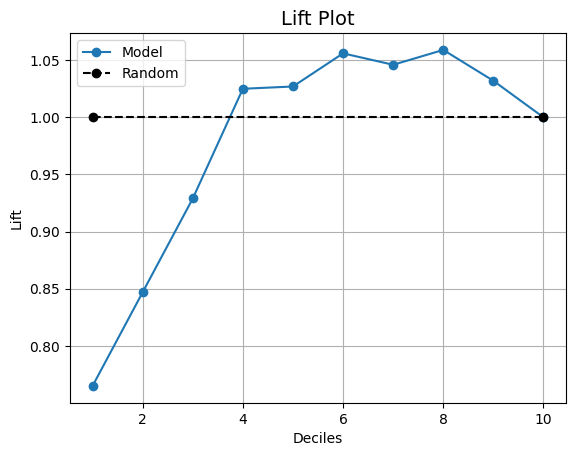

In [ ]:
# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_0.predict_proba(val_sample_set.drop(columns=['TARGET']))[:, 1]

# Use kds.metrics.plot_lift instead of scikitplot
kds.metrics.plot_lift(val_sample_labels, y_proba)
plt.show()

### Matrice de confusion

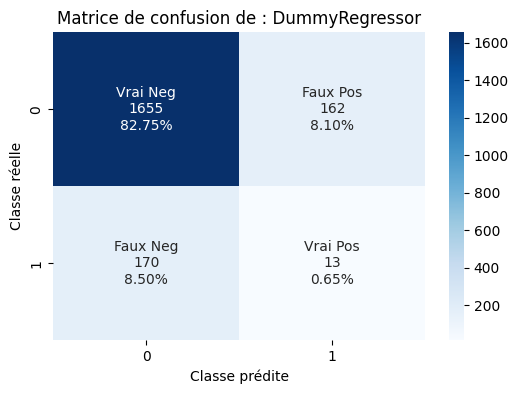

Durée d'exécution de afficher_matrice_confusion: 0.20928478240966797s


In [ ]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba, "DummyRegressor")

In [ ]:
save_folder = '/content/drive/MyDrive/Projet 7/DummyRegressor'
with open(os.path.join(save_folder, 'best_par_0.pkl'), 'wb') as f:
    pickle.dump(best_par_0, f)

with open(os.path.join(save_folder, 'model_0.pkl'), 'wb') as f:
    pickle.dump(model_0, f)


In [ ]:
best_par_0 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/best_par_0.pkl", "rb"))
model_0 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_0.pkl", "rb"))

## Smote

In [ ]:
best_par_smote, model_smote = optimisation_model(train_sample_set, DummyClassifier(strategy='stratified',random_state=seed),metric = cout_metier,smote = True, n_ite_baye=5)

100%|██████████| 5/5 [00:07<00:00,  1.50s/trial, best loss: 0.49220760984054235]
Durée d'exécution de optimisation_model: 7.497583389282227s


### Best parameters

In [ ]:
best_par_smote

{'seuil': 0.225}

### Metrics vs Threshold

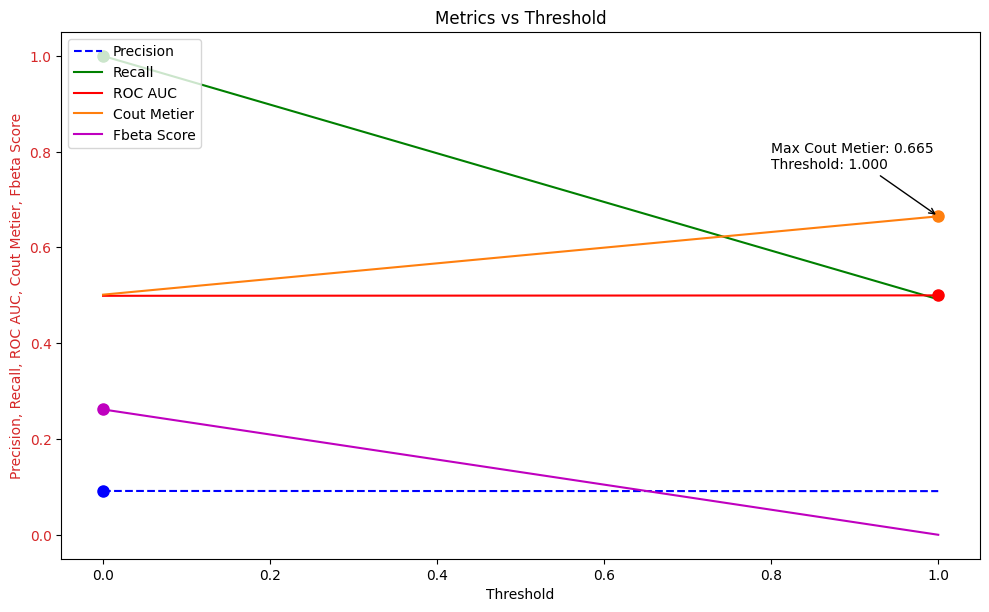

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, fbeta_score


# Assuming X_train is your training features, y_train is your training labels, and model_smote is your trained model
# Metrics to visualize
metrics_to_visualize = [roc_auc_score, recall_score, f1_score, precision_score, fbeta_score]


# Function to calculate metrics at different thresholds
def calculate_metrics(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]
    fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds]

    return thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores

# Function to plot metrics vs threshold
def plot_metrics_vs_threshold(X, y, model, metrics_to_visualize):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores = calculate_metrics(X, y, model)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision, Recall, ROC AUC, Cout Metier, Fbeta Score', color='tab:red')
    ax1.plot(thresholds, precision[:-1], 'b--', label='Precision')
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax1.plot(thresholds, roc_auc, 'r-', label='ROC AUC')
    ax1.plot(thresholds, cout_metier_values, 'tab:orange', label='Cout Metier')
    ax1.plot(thresholds, fbeta_scores, 'm-', label='Fbeta Score')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    ax1.legend(loc='upper left')

    # Mark maximum values
    max_precision_idx = np.argmax(precision[:-1])
    max_recall_idx = np.argmax(recall[:-1])
    max_roc_auc_idx = np.argmax(roc_auc)
    max_cout_metier_idx = np.argmax(cout_metier_values)
    max_fbeta_score_idx = np.argmax(fbeta_scores)

    ax1.plot(thresholds[max_precision_idx], precision[:-1][max_precision_idx], 'bo', markersize=8, label='Max Precision')
    ax1.plot(thresholds[max_recall_idx], recall[:-1][max_recall_idx], 'go', markersize=8, label='Max Recall')
    ax1.plot(thresholds[max_roc_auc_idx], roc_auc[max_roc_auc_idx], 'ro', markersize=8, label='Max ROC AUC')
    ax1.plot(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx], 'o', color='tab:orange', markersize=8, label='Max Cout Metier: {:.3f} (Threshold: {:.3f})'.format(cout_metier_values[max_cout_metier_idx], thresholds[max_cout_metier_idx]))
    ax1.plot(thresholds[max_fbeta_score_idx], fbeta_scores[max_fbeta_score_idx], 'mo', markersize=8, label='Max Fbeta Score: {:.3f} (Threshold: {:.3f})'.format(fbeta_scores[max_fbeta_score_idx], thresholds[max_fbeta_score_idx]))

    # Annotate the maximum Cout Metier value
    ax1.annotate(
        f'Max Cout Metier: {cout_metier_values[max_cout_metier_idx]:.3f}\nThreshold: {thresholds[max_cout_metier_idx]:.3f}',
        xy=(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx]),
        xytext=(thresholds[max_cout_metier_idx] - 0.2, cout_metier_values[max_cout_metier_idx] + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
    )

    fig.tight_layout()
    plt.title('Metrics vs Threshold')
    plt.show()

# usage
plot_metrics_vs_threshold(val_sample_set.drop(columns=['TARGET']), val_sample_labels, model_smote, metrics_to_visualize)


### Metrics

In [ ]:
y_proba_smote = model_smote.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba_smote = y_proba_smote >= 1
y_pred_proba_smote = np.array(y_pred_proba_smote > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score_smote= roc_auc_score(val_sample_labels,y_proba_smote)

# Recall
recall_smote = recall_score(val_sample_labels,y_pred_proba_smote)

# precision
precision_smote = precision_score(val_sample_labels, y_pred_proba_smote)

# F1
f1_smote = f1_score(val_sample_labels, y_pred_proba_smote)

#Fbeta
fbeta_smote = fbeta_score(val_sample_labels, y_pred_proba_smote, beta=2)

print ("ROC auc score : ",score_smote)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_smote))
print("Rappel (recall):", recall_smote)
print("Précision :", precision_smote)
print("F1-score :", f1_smote)
print("Fbeta-score  :", fbeta_smote)


ROC auc score :  0.4990661963062877
métrique métier :  0.5014641288433382
Rappel (recall): 0.4918032786885246
Précision : 0.0911854103343465
F1-score : 0.15384615384615385
Fbeta-score  : 0.26178010471204194


### Lift Curve

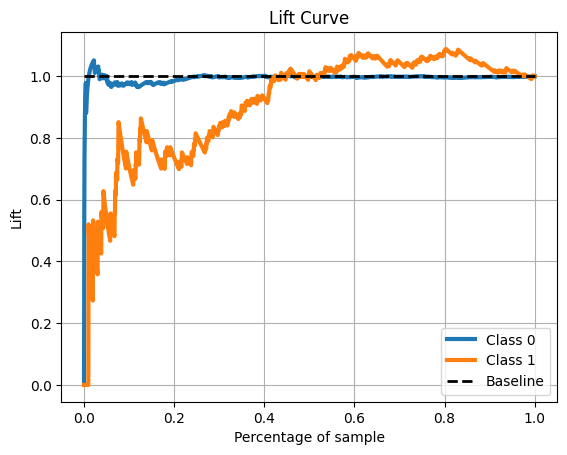

In [ ]:

import scikitplot as skplt
# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_smote.predict_proba(val_sample_set.drop(columns=['TARGET']))
skplt.metrics.plot_lift_curve(val_sample_labels, y_proba)
plt.show()

#skplt.metrics.plot_lift_curve(val_sample_labels, model_us.predict_proba(val_sample_set.drop(columns = ['TARGET'])))[:,1]
plt.show()

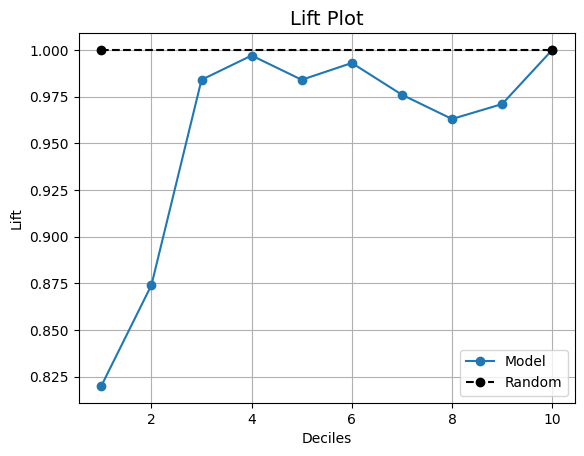

In [ ]:
import kds

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_smote.predict_proba(val_sample_set.drop(columns=['TARGET']))[:, 1]

# Use kds.metrics.plot_lift instead of scikitplot
kds.metrics.plot_lift(val_sample_labels, y_proba)
plt.show()

### Martice de confusion

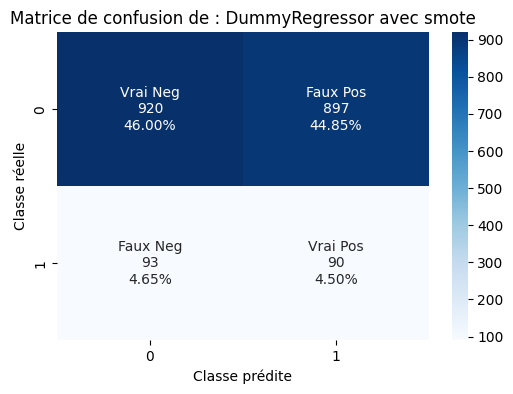

Durée d'exécution de afficher_matrice_confusion: 0.2122325897216797s


In [ ]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_smote, "DummyRegressor avec smote")

In [ ]:
save_folder = '/content/drive/MyDrive/Projet 7/DummyRegressor/'
with open(os.path.join(save_folder, 'best_par_smote.pkl'), 'wb') as f:
    pickle.dump(best_par_smote, f)

with open(os.path.join(save_folder, 'model_smote.pkl'), 'wb') as f:
    pickle.dump(model_smote, f)


In [ ]:
best_par_smote = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/best_par_smote.pkl", "rb"))

model_smote = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_smote.pkl", "rb"))

## UnderSampling

In [ ]:
best_parameters_us,  model_us = optimisation_model(train_sample_set, DummyClassifier(strategy='stratified',random_state=seed),
                                                                             metric=cout_metier, under=True,
                                                                             n_ite_baye=5
                                                                             )

100%|██████████| 5/5 [00:05<00:00,  1.06s/trial, best loss: 0.49210102734290295]
Durée d'exécution de optimisation_model: 5.3137805461883545s


###Best parameters

In [ ]:
best_parameters_us

{'seuil': 0.025}

### Metrics vs Threshold

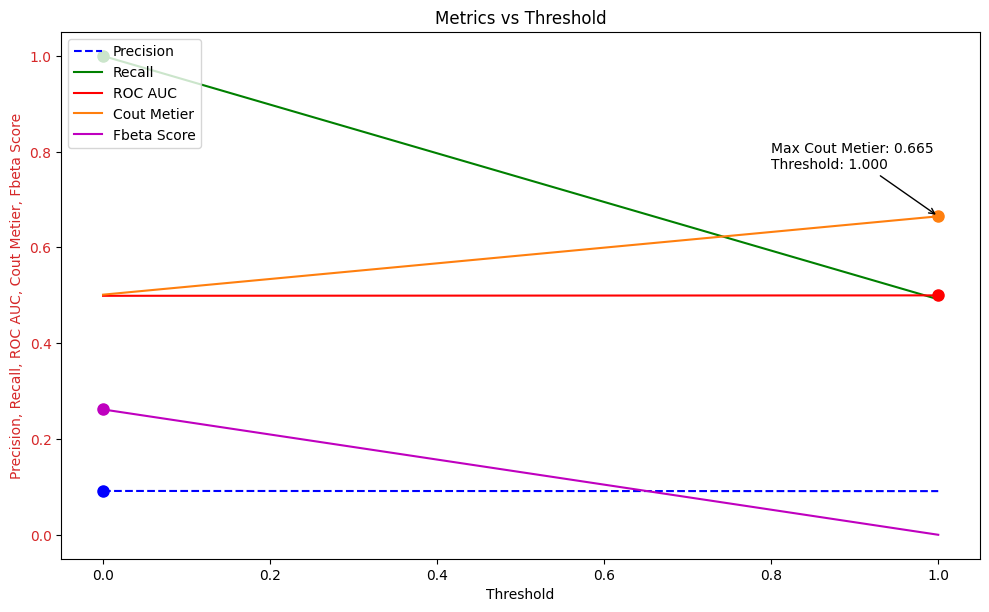

In [ ]:
# Assuming X_train is your training features, y_train is your training labels, and model_smote is your trained model
# Metrics to visualize
metrics_to_visualize = [roc_auc_score, recall_score, f1_score, precision_score, fbeta_score]


# Function to calculate metrics at different thresholds
def calculate_metrics(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]
    fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds]

    return thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores

# Function to plot metrics vs threshold
def plot_metrics_vs_threshold(X, y, model, metrics_to_visualize):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores = calculate_metrics(X, y, model)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision, Recall, ROC AUC, Cout Metier, Fbeta Score', color='tab:red')
    ax1.plot(thresholds, precision[:-1], 'b--', label='Precision')
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax1.plot(thresholds, roc_auc, 'r-', label='ROC AUC')
    ax1.plot(thresholds, cout_metier_values, 'tab:orange', label='Cout Metier')
    ax1.plot(thresholds, fbeta_scores, 'm-', label='Fbeta Score')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    ax1.legend(loc='upper left')

    # Mark maximum values
    max_precision_idx = np.argmax(precision[:-1])
    max_recall_idx = np.argmax(recall[:-1])
    max_roc_auc_idx = np.argmax(roc_auc)
    max_cout_metier_idx = np.argmax(cout_metier_values)
    max_fbeta_score_idx = np.argmax(fbeta_scores)

    ax1.plot(thresholds[max_precision_idx], precision[:-1][max_precision_idx], 'bo', markersize=8, label='Max Precision')
    ax1.plot(thresholds[max_recall_idx], recall[:-1][max_recall_idx], 'go', markersize=8, label='Max Recall')
    ax1.plot(thresholds[max_roc_auc_idx], roc_auc[max_roc_auc_idx], 'ro', markersize=8, label='Max ROC AUC')
    ax1.plot(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx], 'o', color='tab:orange', markersize=8, label='Max Cout Metier: {:.3f} (Threshold: {:.3f})'.format(cout_metier_values[max_cout_metier_idx], thresholds[max_cout_metier_idx]))
    ax1.plot(thresholds[max_fbeta_score_idx], fbeta_scores[max_fbeta_score_idx], 'mo', markersize=8, label='Max Fbeta Score: {:.3f} (Threshold: {:.3f})'.format(fbeta_scores[max_fbeta_score_idx], thresholds[max_fbeta_score_idx]))

    # Annotate the maximum Cout Metier value
    ax1.annotate(
        f'Max Cout Metier: {cout_metier_values[max_cout_metier_idx]:.3f}\nThreshold: {thresholds[max_cout_metier_idx]:.3f}',
        xy=(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx]),
        xytext=(thresholds[max_cout_metier_idx] - 0.2, cout_metier_values[max_cout_metier_idx] + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
    )

    fig.tight_layout()
    plt.title('Metrics vs Threshold')
    plt.show()

# usage
plot_metrics_vs_threshold(val_sample_set.drop(columns=['TARGET']), val_sample_labels, model_us, metrics_to_visualize)


### Metrics

In [ ]:
y_proba_us = model_us.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba_us = (y_proba_us > 0.99)
y_pred_proba_us = np.array(y_pred_proba_us > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score_us= roc_auc_score(val_sample_labels,y_proba_us)

# Recall
recall_us = recall_score(val_sample_labels,y_pred_proba_us)

# precision
precision_us = precision_score(val_sample_labels, y_pred_proba_us)

# F1
f1_us = f1_score(val_sample_labels, y_pred_proba_us)

#Fbeta
fbeta_us = fbeta_score(val_sample_labels, y_pred_proba_us, beta=2)

print ("ROC auc score : ",score_us)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_us))
print("Rappel (recall):", recall_us)
print("Précision :", precision_us)
print("F1-score :", f1_us)
print("Fbeta-score  :", fbeta_us)



ROC auc score :  0.4990661963062877
métrique métier :  0.5014641288433382
Rappel (recall): 0.4918032786885246
Précision : 0.0911854103343465
F1-score : 0.15384615384615385
Fbeta-score  : 0.26178010471204194


### Lift curve

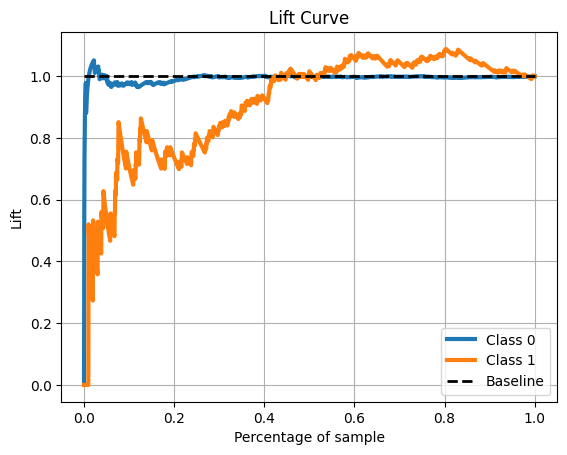

In [ ]:

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_us.predict_proba(val_sample_set.drop(columns=['TARGET']))
skplt.metrics.plot_lift_curve(val_sample_labels, y_proba)
plt.show()

#skplt.metrics.plot_lift_curve(val_sample_labels, model_us.predict_proba(val_sample_set.drop(columns = ['TARGET'])))[:,1]
plt.show()

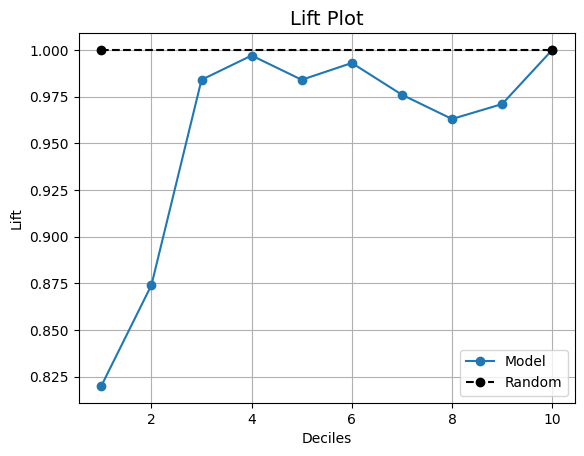

In [ ]:
import kds

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_us.predict_proba(val_sample_set.drop(columns=['TARGET']))[:, 1]

# Use kds.metrics.plot_lift instead of scikitplot
kds.metrics.plot_lift(val_sample_labels, y_proba)
plt.show()

### Matrice de confusion

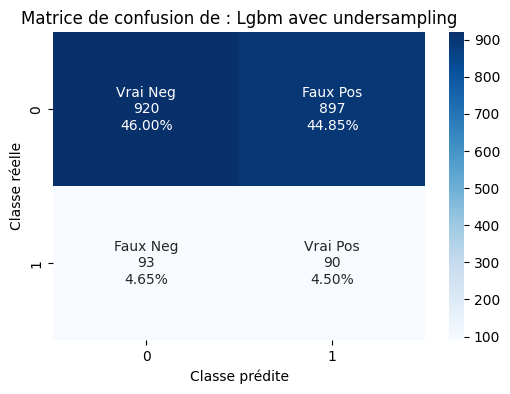

Durée d'exécution de afficher_matrice_confusion: 0.21610260009765625s


In [ ]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_us, "Lgbm avec undersampling")

In [ ]:
save_folder = '/content/drive/MyDrive/Projet 7/DummyRegressor/'
with open(os.path.join(save_folder, 'best_parameters_us.pkl'), 'wb') as f:
    pickle.dump(best_parameters_us, f)


with open(os.path.join(save_folder, 'model_us.pkl'), 'wb') as f:
    pickle.dump(model_us, f)


In [ ]:
best_parameters_us = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/best_parameters_us.pkl", "rb"))
model_us = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_us.pkl", "rb"))

## SMOTE 0.6

In [ ]:
best_parameters_su06, model_su06 = optimisation_model(train_sample_set, DummyClassifier(strategy='stratified',random_state=seed),
                                                                             metric=cout_metier, sm_un=True,
                                                                             n_ite_baye=5
                                                                             )

100%|██████████| 5/5 [00:09<00:00,  1.97s/trial, best loss: 0.49218077484394573]
Durée d'exécution de optimisation_model: 9.874633550643921s


### Metrics vs Threshold

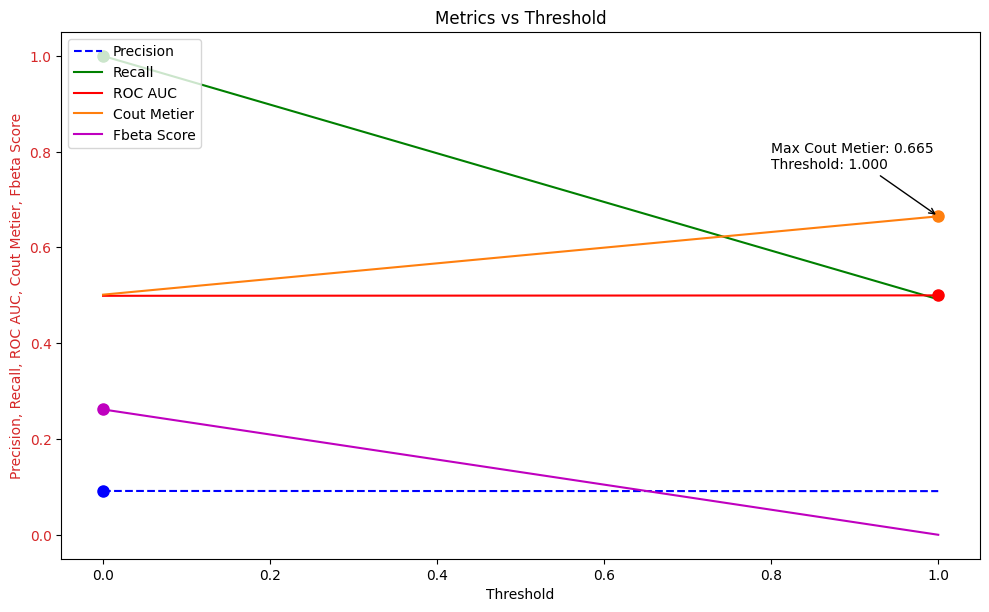

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, fbeta_score


# Assuming X_train is your training features, y_train is your training labels, and model_smote is your trained model
# Metrics to visualize
metrics_to_visualize = [roc_auc_score, recall_score, f1_score, precision_score, fbeta_score]


# Function to calculate metrics at different thresholds
def calculate_metrics(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]
    fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds]

    return thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores

# Function to plot metrics vs threshold
def plot_metrics_vs_threshold(X, y, model, metrics_to_visualize):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores = calculate_metrics(X, y, model)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision, Recall, ROC AUC, Cout Metier, Fbeta Score', color='tab:red')
    ax1.plot(thresholds, precision[:-1], 'b--', label='Precision')
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax1.plot(thresholds, roc_auc, 'r-', label='ROC AUC')
    ax1.plot(thresholds, cout_metier_values, 'tab:orange', label='Cout Metier')
    ax1.plot(thresholds, fbeta_scores, 'm-', label='Fbeta Score')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    ax1.legend(loc='upper left')

    # Mark maximum values
    max_precision_idx = np.argmax(precision[:-1])
    max_recall_idx = np.argmax(recall[:-1])
    max_roc_auc_idx = np.argmax(roc_auc)
    max_cout_metier_idx = np.argmax(cout_metier_values)
    max_fbeta_score_idx = np.argmax(fbeta_scores)

    ax1.plot(thresholds[max_precision_idx], precision[:-1][max_precision_idx], 'bo', markersize=8, label='Max Precision')
    ax1.plot(thresholds[max_recall_idx], recall[:-1][max_recall_idx], 'go', markersize=8, label='Max Recall')
    ax1.plot(thresholds[max_roc_auc_idx], roc_auc[max_roc_auc_idx], 'ro', markersize=8, label='Max ROC AUC')
    ax1.plot(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx], 'o', color='tab:orange', markersize=8, label='Max Cout Metier: {:.3f} (Threshold: {:.3f})'.format(cout_metier_values[max_cout_metier_idx], thresholds[max_cout_metier_idx]))
    ax1.plot(thresholds[max_fbeta_score_idx], fbeta_scores[max_fbeta_score_idx], 'mo', markersize=8, label='Max Fbeta Score: {:.3f} (Threshold: {:.3f})'.format(fbeta_scores[max_fbeta_score_idx], thresholds[max_fbeta_score_idx]))

    # Annotate the maximum Cout Metier value
    ax1.annotate(
        f'Max Cout Metier: {cout_metier_values[max_cout_metier_idx]:.3f}\nThreshold: {thresholds[max_cout_metier_idx]:.3f}',
        xy=(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx]),
        xytext=(thresholds[max_cout_metier_idx] - 0.2, cout_metier_values[max_cout_metier_idx] + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
    )

    fig.tight_layout()
    plt.title('Metrics vs Threshold')
    plt.show()

# usage
plot_metrics_vs_threshold(val_sample_set.drop(columns=['TARGET']), val_sample_labels, model_su06, metrics_to_visualize)


### Metrics

In [ ]:
y_proba_su06 = model_su06.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba_su06 = y_proba_su06 > 0.99
y_proba_su06_acc = y_proba_su06 > 0.5
y_pred_proba_su06 = np.array(y_pred_proba_su06 > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score_su06= roc_auc_score(val_sample_labels,y_proba_su06)

# Accuracy
accuracy_su06 = accuracy_score(val_sample_labels, y_proba_su06_acc)

# Accuracy_fin
accuracy_su06_fin = accuracy_score(val_sample_labels, y_pred_proba_su06)

# Recall
recall_su06 = recall_score(val_sample_labels,y_pred_proba_su06)

# precision
precision_su06 = precision_score(val_sample_labels, y_pred_proba_su06)

# F1
f1_su06 = f1_score(val_sample_labels, y_pred_proba_su06)

#Fbeta
fbeta_su06 = fbeta_score(val_sample_labels, y_pred_proba_su06, beta=2)

print ("ROC auc score : ",score_su06)
print('Acuracy :', accuracy_su06)
print('Acuracy fin :', accuracy_su06_fin)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_su06))
print("Rappel (recall):", recall_su06)
print("Précision :", precision_su06)
print("F1-score :", f1_su06)
print("Fbeta-score  :", fbeta_su06)



ROC auc score :  0.4990661963062877
Acuracy : 0.505
Acuracy fin : 0.505
métrique métier :  0.5014641288433382
Rappel (recall): 0.4918032786885246
Précision : 0.0911854103343465
F1-score : 0.15384615384615385
Fbeta-score  : 0.26178010471204194


### Lift Curve

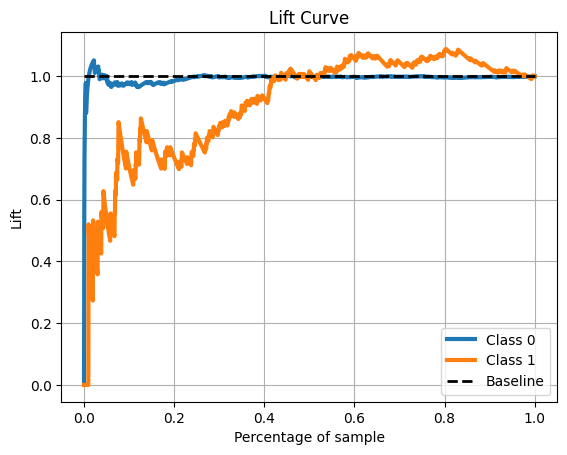

In [ ]:

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_su06.predict_proba(val_sample_set.drop(columns=['TARGET']))
skplt.metrics.plot_lift_curve(val_sample_labels, y_proba)
plt.show()

#skplt.metrics.plot_lift_curve(val_sample_labels, model_us.predict_proba(val_sample_set.drop(columns = ['TARGET'])))[:,1]
plt.show()

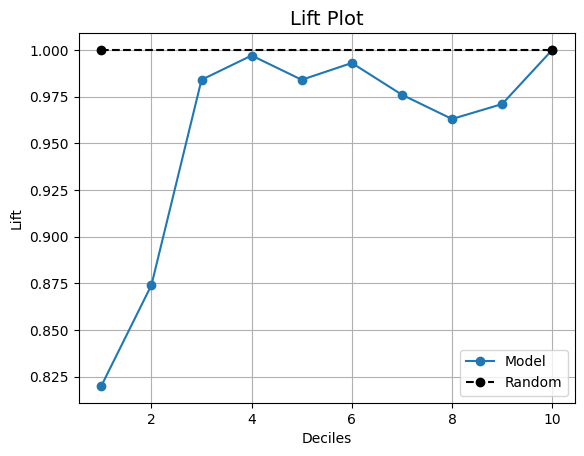

In [ ]:
import kds

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_su06.predict_proba(val_sample_set.drop(columns=['TARGET']))[:, 1]

# Use kds.metrics.plot_lift instead of scikitplot
kds.metrics.plot_lift(val_sample_labels, y_proba)
plt.show()

### Matrice de confusion

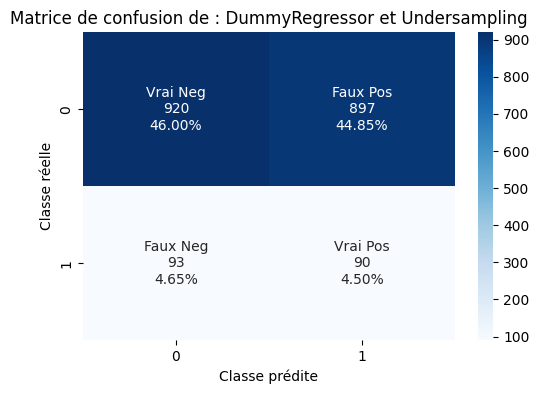

Durée d'exécution de afficher_matrice_confusion: 0.2731297016143799s


In [ ]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_su06, "DummyRegressor et Undersampling")

In [ ]:
save_folder = '/content/drive/MyDrive/Projet 7/DummyRegressor/'
with open(os.path.join(save_folder, 'best_parameters_su06.pkl'), 'wb') as f:
    pickle.dump(best_parameters_su06, f)

with open(os.path.join(save_folder, 'model_su06.pkl'), 'wb') as f:
    pickle.dump(model_su06, f)


In [ ]:
best_parameters_su06 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/best_parameters_su06.pkl", "rb"))

model_su06 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_su06.pkl", "rb"))

## Smote 0.4

In [ ]:
best_parameters_su04,  model_su04 = optimisation_model(train_sample_set, DummyClassifier(strategy='stratified',random_state=seed),
                                                                             metric=cout_metier, sm_un=True,
                                                                             n_ite_baye=5
                                                                             )

100%|██████████| 5/5 [00:06<00:00,  1.24s/trial, best loss: 0.4921142403395965]
Durée d'exécution de optimisation_model: 6.232162952423096s


### Best parameters

In [ ]:
best_parameters_su04

{'seuil': 0.05}

### Metrics vs Threshold

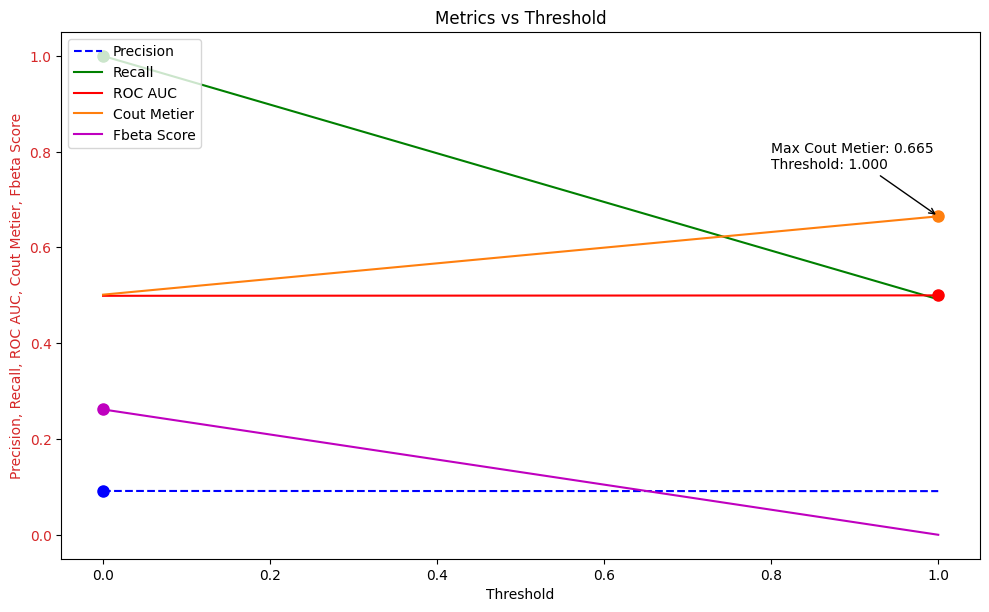

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, fbeta_score


# Assuming X_train is your training features, y_train is your training labels, and model_smote is your trained model
# Metrics to visualize
metrics_to_visualize = [roc_auc_score, recall_score, f1_score, precision_score, fbeta_score]


# Function to calculate metrics at different thresholds
def calculate_metrics(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]
    fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds]

    return thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores

# Function to plot metrics vs threshold
def plot_metrics_vs_threshold(X, y, model, metrics_to_visualize):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores = calculate_metrics(X, y, model)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision, Recall, ROC AUC, Cout Metier, Fbeta Score', color='tab:red')
    ax1.plot(thresholds, precision[:-1], 'b--', label='Precision')
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax1.plot(thresholds, roc_auc, 'r-', label='ROC AUC')
    ax1.plot(thresholds, cout_metier_values, 'tab:orange', label='Cout Metier')
    ax1.plot(thresholds, fbeta_scores, 'm-', label='Fbeta Score')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    ax1.legend(loc='upper left')

    # Mark maximum values
    max_precision_idx = np.argmax(precision[:-1])
    max_recall_idx = np.argmax(recall[:-1])
    max_roc_auc_idx = np.argmax(roc_auc)
    max_cout_metier_idx = np.argmax(cout_metier_values)
    max_fbeta_score_idx = np.argmax(fbeta_scores)

    ax1.plot(thresholds[max_precision_idx], precision[:-1][max_precision_idx], 'bo', markersize=8, label='Max Precision')
    ax1.plot(thresholds[max_recall_idx], recall[:-1][max_recall_idx], 'go', markersize=8, label='Max Recall')
    ax1.plot(thresholds[max_roc_auc_idx], roc_auc[max_roc_auc_idx], 'ro', markersize=8, label='Max ROC AUC')
    ax1.plot(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx], 'o', color='tab:orange', markersize=8, label='Max Cout Metier: {:.3f} (Threshold: {:.3f})'.format(cout_metier_values[max_cout_metier_idx], thresholds[max_cout_metier_idx]))
    ax1.plot(thresholds[max_fbeta_score_idx], fbeta_scores[max_fbeta_score_idx], 'mo', markersize=8, label='Max Fbeta Score: {:.3f} (Threshold: {:.3f})'.format(fbeta_scores[max_fbeta_score_idx], thresholds[max_fbeta_score_idx]))

    # Annotate the maximum Cout Metier value
    ax1.annotate(
        f'Max Cout Metier: {cout_metier_values[max_cout_metier_idx]:.3f}\nThreshold: {thresholds[max_cout_metier_idx]:.3f}',
        xy=(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx]),
        xytext=(thresholds[max_cout_metier_idx] - 0.2, cout_metier_values[max_cout_metier_idx] + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
    )

    fig.tight_layout()
    plt.title('Metrics vs Threshold')
    plt.show()

# usage
plot_metrics_vs_threshold(val_sample_set.drop(columns=['TARGET']), val_sample_labels, model_su04, metrics_to_visualize)


### Mertics

In [ ]:
y_proba_su04 = model_su04.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
#y_pred_proba_su04 = y_proba_su04 > 0.48
y_pred_proba_su04 = y_proba_su04 > 0.99
y_proba_su04_acc = y_proba_su04 > 0.5
y_pred_proba_su04 = np.array(y_pred_proba_su04 > 0)*1

# Si proba > seuil alors la prédiction est positive : 1
score_su04= roc_auc_score(val_sample_labels,y_proba_su04)

# Accuracy
accuracy_su04 = accuracy_score(val_sample_labels, y_proba_su04_acc)

accuracy_su04_fin = accuracy_score(val_sample_labels, y_pred_proba_su04)

# Recall
recall_su04 = recall_score(val_sample_labels,y_pred_proba_su04)

# precision
precision_su04 = precision_score(val_sample_labels, y_pred_proba_su04)

# F1
f1_su04 = f1_score(val_sample_labels, y_pred_proba_su04)

# Fbeta

fbeta_su04 = fbeta_score(val_sample_labels, y_pred_proba_su04, beta=2)

#print('Seuil : ', best_parameters_su04['seuil'])
print ("ROC auc score : ",score_su04)
print('Acuracy :', accuracy_su04)

print('Acuracy_fin :', accuracy_su04_fin)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_su04))
print("Rappel (recall):", recall_su04)
print("Précision :", precision_su04)
print("F1-score :", f1_su04)
print("Fbeta-score  :", fbeta_su04)


ROC auc score :  0.4990661963062877
Acuracy : 0.505
Acuracy_fin : 0.505
métrique métier :  0.5014641288433382
Rappel (recall): 0.4918032786885246
Précision : 0.0911854103343465
F1-score : 0.15384615384615385
Fbeta-score  : 0.26178010471204194


### Lift curve

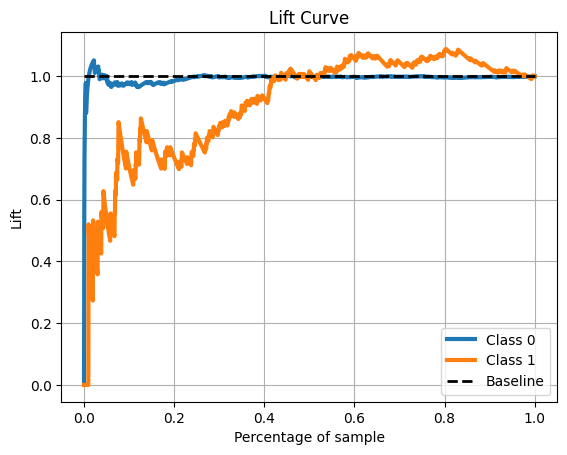

In [ ]:

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_su04.predict_proba(val_sample_set.drop(columns=['TARGET']))
skplt.metrics.plot_lift_curve(val_sample_labels, y_proba)
plt.show()

#skplt.metrics.plot_lift_curve(val_sample_labels, model_us.predict_proba(val_sample_set.drop(columns = ['TARGET'])))[:,1]
plt.show()

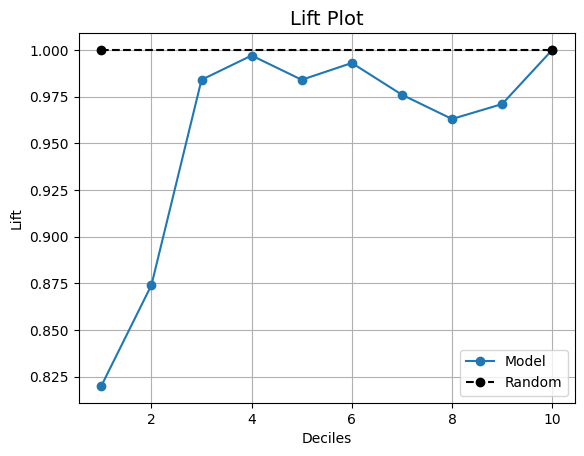

In [ ]:
import kds

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_su04.predict_proba(val_sample_set.drop(columns=['TARGET']))[:, 1]

# Use kds.metrics.plot_lift instead of scikitplot
kds.metrics.plot_lift(val_sample_labels, y_proba)
plt.show()

### Martice de confusion

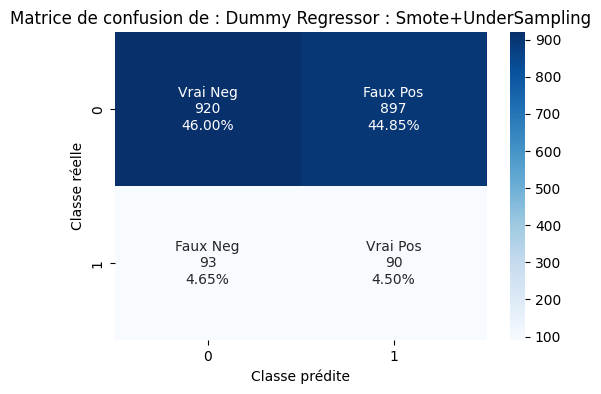

Durée d'exécution de afficher_matrice_confusion: 0.22988128662109375s


In [ ]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_su04, "Dummy Regressor : Smote+UnderSampling")

In [ ]:
save_folder = '/content/drive/MyDrive/Projet 7/DummyRegressor'
with open(os.path.join(save_folder, 'best_parameters_su04.pkl'), 'wb') as f:
    pickle.dump(best_parameters_su04, f)

with open(os.path.join(save_folder, 'model_su04.pkl'), 'wb') as f:
    pickle.dump(model_su04, f)


In [ ]:
best_parameters_su04 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/best_parameters_su04.pkl", "rb"))
model_su04 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_su04.pkl", "rb"))

## Smote 0.2

In [ ]:
best_parameters_su02, model_su02 = optimisation_model(train_sample_set, DummyClassifier(strategy='stratified',random_state=seed),
                                                                             metric=cout_metier, sm_un=True,
                                                                             n_ite_baye=5
                                                                             )

100%|██████████| 5/5 [00:08<00:00,  1.76s/trial, best loss: 0.4921674049692767]
Durée d'exécution de optimisation_model: 8.82012128829956s


### Best parametres

In [ ]:
best_parameters_su02

{'seuil': 0.15000000000000002}

### Metrics vs Threshold

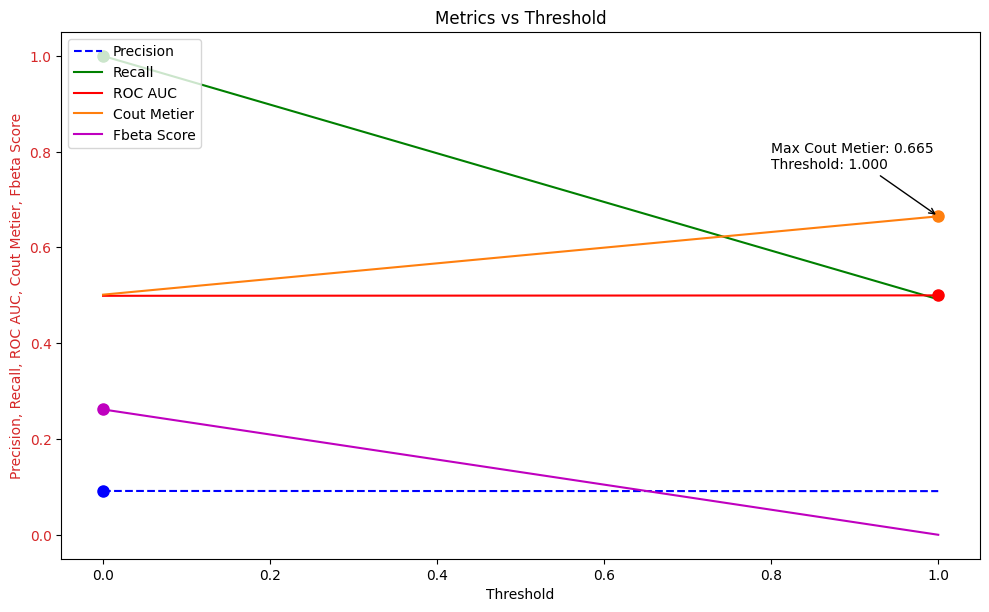

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, fbeta_score


# Assuming X_train is your training features, y_train is your training labels, and model_smote is your trained model
# Metrics to visualize
metrics_to_visualize = [roc_auc_score, recall_score, f1_score, precision_score, fbeta_score]


# Function to calculate metrics at different thresholds
def calculate_metrics(X, y, model):
    y_pred_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_pred_proba)
    roc_auc = [roc_auc_score(y, y_pred_proba > threshold) for threshold in thresholds]
    cout_metier_values = [cout_metier(y, y_pred_proba > threshold) for threshold in thresholds]
    fbeta_scores = [fbeta_score(y, y_pred_proba > threshold, beta=2) for threshold in thresholds]

    return thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores

# Function to plot metrics vs threshold
def plot_metrics_vs_threshold(X, y, model, metrics_to_visualize):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    thresholds, precision, recall, roc_auc, cout_metier_values, fbeta_scores = calculate_metrics(X, y, model)

    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Precision, Recall, ROC AUC, Cout Metier, Fbeta Score', color='tab:red')
    ax1.plot(thresholds, precision[:-1], 'b--', label='Precision')
    ax1.plot(thresholds, recall[:-1], 'g-', label='Recall')
    ax1.plot(thresholds, roc_auc, 'r-', label='ROC AUC')
    ax1.plot(thresholds, cout_metier_values, 'tab:orange', label='Cout Metier')
    ax1.plot(thresholds, fbeta_scores, 'm-', label='Fbeta Score')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    ax1.legend(loc='upper left')

    # Mark maximum values
    max_precision_idx = np.argmax(precision[:-1])
    max_recall_idx = np.argmax(recall[:-1])
    max_roc_auc_idx = np.argmax(roc_auc)
    max_cout_metier_idx = np.argmax(cout_metier_values)
    max_fbeta_score_idx = np.argmax(fbeta_scores)

    ax1.plot(thresholds[max_precision_idx], precision[:-1][max_precision_idx], 'bo', markersize=8, label='Max Precision')
    ax1.plot(thresholds[max_recall_idx], recall[:-1][max_recall_idx], 'go', markersize=8, label='Max Recall')
    ax1.plot(thresholds[max_roc_auc_idx], roc_auc[max_roc_auc_idx], 'ro', markersize=8, label='Max ROC AUC')
    ax1.plot(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx], 'o', color='tab:orange', markersize=8, label='Max Cout Metier: {:.3f} (Threshold: {:.3f})'.format(cout_metier_values[max_cout_metier_idx], thresholds[max_cout_metier_idx]))
    ax1.plot(thresholds[max_fbeta_score_idx], fbeta_scores[max_fbeta_score_idx], 'mo', markersize=8, label='Max Fbeta Score: {:.3f} (Threshold: {:.3f})'.format(fbeta_scores[max_fbeta_score_idx], thresholds[max_fbeta_score_idx]))

    # Annotate the maximum Cout Metier value
    ax1.annotate(
        f'Max Cout Metier: {cout_metier_values[max_cout_metier_idx]:.3f}\nThreshold: {thresholds[max_cout_metier_idx]:.3f}',
        xy=(thresholds[max_cout_metier_idx], cout_metier_values[max_cout_metier_idx]),
        xytext=(thresholds[max_cout_metier_idx] - 0.2, cout_metier_values[max_cout_metier_idx] + 0.1),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
    )

    fig.tight_layout()
    plt.title('Metrics vs Threshold')
    plt.show()

# usage
plot_metrics_vs_threshold(val_sample_set.drop(columns=['TARGET']), val_sample_labels, model_su02, metrics_to_visualize)


### Metrics

In [ ]:
y_proba_su02 = model_su02.predict_proba(val_sample_set.drop(columns = ['TARGET']))[:, 1]
y_pred_proba_su02 = y_proba_su02 > 0.99
y_proba_su02_acc = y_proba_su02 > 0.5
y_pred_proba_su02 = np.array(y_pred_proba_su02 > 0)*1

# Roc_auc_score
score_su02= roc_auc_score(val_sample_labels,y_proba_su02)

# Accuracy
accuracy_su02 = accuracy_score(val_sample_labels, y_proba_su02_acc)

# Accuracy_fin
accuracy_su02_fin = accuracy_score(val_sample_labels, y_pred_proba_su02)

# Recall
recall_su02 = recall_score(val_sample_labels,y_pred_proba_su02)

# precision
precision_su02 = precision_score(val_sample_labels, y_pred_proba_su02)

# F1
f1_su02 = f1_score(val_sample_labels, y_pred_proba_su02)

# F beta
fbeta_su02 = fbeta_score(val_sample_labels, y_pred_proba_su02, beta=2)

#print('Seuil : ', best_parameters_su02['seuil'])
print ("ROC auc score : ",score_su02)
print('Acuracy :', accuracy_su02)
print('Acuracy fin :', accuracy_su02_fin)
print("métrique métier : ",cout_metier(val_sample_labels,y_pred_proba_su02))
print("Rappel (recall):", recall_su02)
print("Précision :", precision_su02)
print("F1-score :", f1_su02)
print("Fbeta-score  :", fbeta_su02)


ROC auc score :  0.4990661963062877
Acuracy : 0.505
Acuracy fin : 0.505
métrique métier :  0.5014641288433382
Rappel (recall): 0.4918032786885246
Précision : 0.0911854103343465
F1-score : 0.15384615384615385
Fbeta-score  : 0.26178010471204194


### Lift Curve

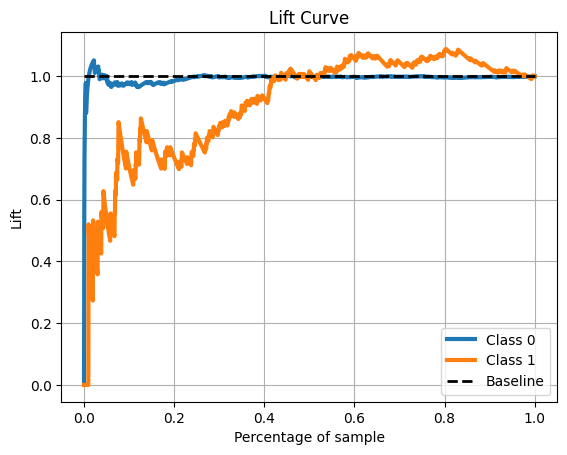

In [ ]:

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_su02.predict_proba(val_sample_set.drop(columns=['TARGET']))
skplt.metrics.plot_lift_curve(val_sample_labels, y_proba)
plt.show()

#skplt.metrics.plot_lift_curve(val_sample_labels, model_us.predict_proba(val_sample_set.drop(columns = ['TARGET'])))[:,1]
plt.show()

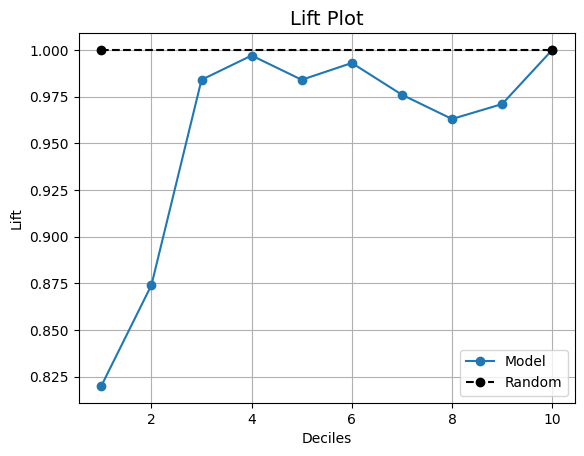

In [ ]:
import kds

# Assuming model_us is your classifier and val_sample_set is your validation dataset
y_proba = model_su02.predict_proba(val_sample_set.drop(columns=['TARGET']))[:, 1]

# Use kds.metrics.plot_lift instead of scikitplot
kds.metrics.plot_lift(val_sample_labels, y_proba)
plt.show()

### Matrice de confusion

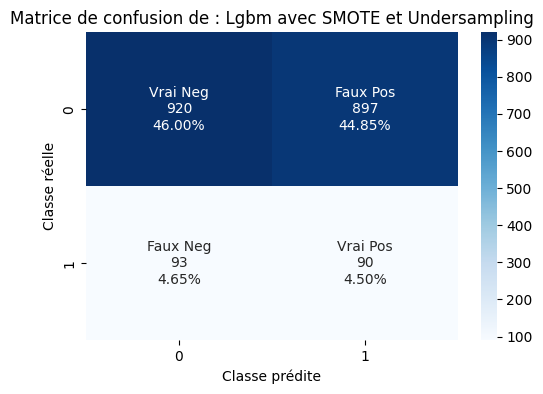

Durée d'exécution de afficher_matrice_confusion: 0.2384185791015625s


In [ ]:
afficher_matrice_confusion(val_sample_labels,y_pred_proba_su02, "Lgbm avec SMOTE et Undersampling")

In [ ]:
save_folder = '/content/drive/MyDrive/Projet 7/DummyRegressor'
with open(os.path.join(save_folder, 'best_parameters_su02.pkl'), 'wb') as f:
    pickle.dump(best_parameters_su02, f)

with open(os.path.join(save_folder, 'model_su02.pkl'), 'wb') as f:
    pickle.dump(model_su02, f)


In [ ]:
best_parameters_su02 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/best_parameters_su02.pkl", "rb"))

model_su02 = pickle.load(open("/content/drive/MyDrive/Projet 7/DummyRegressor/model_su02.pkl", "rb"))